In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import GPy
import math
import pylab as pb
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import geatpy as ea
from hpelm import ELM

In [22]:
"""===============================导入数据==========================="""
dat = pd.read_csv('SH18.csv')
gy = np.array(dat["volume"])[1:132]
LL = np.array(dat["LL"])[1:132]
UU = np.array(dat["UU"])[1:132]
sea = np.array(dat["sea"])[0:131]
f1 = np.array(dat["CIMF1"])[0:131]
f2 = np.array(dat["CIMF2"])[0:131]
f3 = np.array(dat["CIMF3"])[0:131]
f4 = np.array(dat["CIMF4"])[0:131]
f5 = np.array(dat["CR"])[0:131]

gx=np.column_stack((sea,f1,f2,f3,f4,f5))# 训练集的输入
gy2=np.column_stack((LL,UU))# 训练集的输出（假的上下边界）
gy.resize((131, 1))# 训练集对应的输出真实值

seat = np.array(dat["sea"])[131:143]
f1t = np.array(dat["CIMF1"])[131:143]
f2t = np.array(dat["CIMF2"])[131:143]
f3t = np.array(dat["CIMF3"])[131:143]
f4t = np.array(dat["CIMF4"])[131:143]
f5t = np.array(dat["CR"])[131:143]

testt = np.array(dat["volume"])[132:144]
testt.resize((12, 1))# 测试集对应的输出真实值

gxt=np.column_stack((seat,f1t,f2t,f3t,f4t,f5t))# 测试集的输入


"""===============================数据预处理==========================="""
scaler1 = StandardScaler()


scaler1.fit(gx)


gx = scaler1.transform(gx)  
gxt = scaler1.transform(gxt)


In [31]:
"""===============================用假的上下边界训练一下ELM，顺便随机生成隐含层的权值W和阈值B==========================="""
Telm = ELM(6, 2)
Telm.add_neurons(10, "sigm")
Telm.train(gx, gy2, "r")
bb = Telm.predict(gx)
print(bb)# 观察一下结果

"""===============================计算结果的PICP 和 PINAW==========================="""
LOW = []
UP = []

for s in range(0,131):
    if bb[s,0] >= bb[s,1]:
        LOW.append(bb[s,1])
        UP.append(bb[s,0])
    else:
        LOW.append(bb[s,0])
        UP.append(bb[s,1])

ACE = 0
    
for s in range(0,131):
    if gy[s] >= LOW[s] and gy[s] <= UP[s]:
        eve = 1
    else:
        eve = 0
    ACE = ACE + eve

PICP = ACE/gy.shape[0]
    

PIW = np.mean(UP)- np.mean(LOW)
PINAW= PIW/(max(gy)- min(gy))
print('PICP=',PICP,'PINAW=',PINAW)# 可以看出假边界数据训练的结果虽然不好，但表现的挺正常
                                   # 但是PINAW基本不会怎么变化，因为假区间是用真实值±43编的，区间宽度固定为43*2，被训练时识别出来了

[[180.88869245 268.10500411]
 [184.51889698 271.71701865]
 [168.34048941 252.22024099]
 [160.96247063 247.81197836]
 [193.90525715 283.21341507]
 [180.04259901 262.28984707]
 [242.41867778 331.67777662]
 [252.47281818 340.14939176]
 [220.63174718 306.3404223 ]
 [215.42033522 302.11879044]
 [210.24388388 289.86593477]
 [222.9556547  298.91682768]
 [348.25469369 447.05598863]
 [258.13057084 339.57137894]
 [239.38563478 322.1288461 ]
 [269.03994884 360.33832183]
 [326.47397605 426.92497075]
 [145.06926682 225.83425798]
 [170.54756091 256.42481504]
 [218.03935202 304.37800854]
 [175.65567582 253.8684821 ]
 [196.5505502  284.44617899]
 [154.23939921 234.05801508]
 [241.11915914 333.15334964]
 [204.90380312 286.12893045]
 [256.71178835 345.49275501]
 [238.64845899 327.35169931]
 [207.62492127 288.28291451]
 [168.61308719 246.81862081]
 [197.27204592 280.178702  ]
 [286.50764218 371.73750381]
 [294.74454374 379.55718715]
 [214.39795265 295.53658973]
 [327.42415493 414.65525692]
 [159.97043706

In [32]:
"""===============================定义多目标优化算法要解决的问题==========================="""

class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'MyProblem' # 初始化name（函数名称，可以随意设置）
        M = 2 # 初始化M（目标维数）
        maxormins = [-1,1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 20 # 初始化Dim（决策变量维数，即ELM的输出层的权值矩阵10*2）
        varTypes = [0]* Dim # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [-10000] * Dim # 决策变量下界
        ub = [10000] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
    
    def aimFunc(self, pop): # 目标函数，f1是PICP，f2是PINAW
        Vars = pop.Phen # 得到决策变量矩阵
        pop.ObjV = np.zeros((pop.sizes, 2)) # 初始化种群个体目标函数值列向量
        for i in range(0,pop.sizes):# 计算目标函数值
            Q = Vars[i]
            SB = Q.reshape((10, 2))
            
            Telm.nnet.set_B(SB)# 把优化算法得出的权值B矩阵带入ELM
    
            bb=Telm.predict(gx)
            LOW = []
            UP = []

            for s in range(0,131):  # 计算上下边界
                if bb[s,0] >= bb[s,1]:
                    LOW.append(bb[s,1])
                    UP.append(bb[s,0])
                else:
                    LOW.append(bb[s,0])
                    UP.append(bb[s,1])

            ACE = 0
    
            for s in range(0,gy.shape[0]):
                if gy[s] >= LOW[s] and gy[s] <= UP[s]:
                     eve = 1
                else:
                     eve = 0
                ACE = ACE + eve

            f1 = ACE/gy.shape[0]# 计算PICP
    

            PIW = np.mean(UP)- np.mean(LOW)
            f2 = PIW/(max(gy)- min(gy))# 计算PINAW
            pop.ObjV[i] = [f1,f2] 


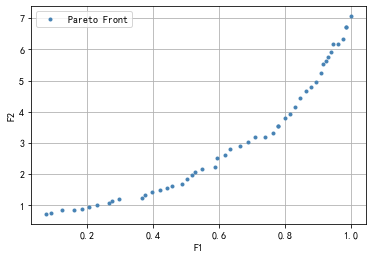

用时：22.951664 秒
评价次数：25000次
非支配个体数：50个
单位时间找到帕累托前沿点个数：2个
种群信息导出完毕。


In [33]:
"""===============================运行优化算法，得出结果==========================="""

if __name__ == '__main__':
    """===============================实例化问题对象==========================="""
    problem = MyProblem() # 生成问题对象
    """=================================种群设置==============================="""
    Encoding = 'RI'       # 编码方式
    NIND = 50             # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """===============================算法参数设置============================="""
    myAlgorithm = ea.moea_NSGA2_templet(problem, population) # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 500 # 最大进化代数
    myAlgorithm.drawing = 1   # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制过程动画）
    """===========================调用算法模板进行种群进化===========================
    调用run执行算法模板，得到帕累托最优解集NDSet。NDSet是一个种群类Population的对象。
    NDSet.ObjV为最优解个体的目标函数值；NDSet.Phen为对应的决策变量值。
    """
    NDSet = myAlgorithm.run() # 执行算法模板，得到非支配种群
    print('用时：%f 秒'%(myAlgorithm.passTime))
    print('评价次数：%d次'%(myAlgorithm.evalsNum))
    print('非支配个体数：%d个'%(NDSet.sizes))
    print('单位时间找到帕累托前沿点个数：%d个'%(int(NDSet.sizes //myAlgorithm.passTime)))
NDSet.save()

In [34]:
# 从上图可以看出得到的解非常的失败，PINAW甚至都大于1，从非支配种群中随便拉出一个解来看看训练集的预测结果
print(NDSet.ObjV[13])

Q = NDSet.Phen[13]
SB = Q.reshape((10, 2))

Telm.nnet.set_B(SB)

bb=Telm.predict(gx)
print(bb)


"""可以看出得到的结果非常脱离实际，之后尝试了其他数据预处理方法 ：MinMaxScaler 和 RobustScaler
   最大的PINAW可以缩小一点，到3-5左右，但预测结果依旧脱离实际"""

[0.89312977 4.95466762]
[[   7964.25500553  212336.47953687]
 [  25168.84527362  222633.5590532 ]
 [-231931.14993516  128962.81174585]
 [  26746.21567082  246799.75435304]
 [  -7354.34216443  206244.35077454]
 [-198567.2119835   100416.76572033]
 [ -73420.44149777  109732.91693777]
 [ -73623.39754061   82166.11625049]
 [-108911.14402466   33213.4623336 ]
 [ -61926.51006601   53239.06806041]
 [-112007.36166918  128117.46244212]
 [-157177.08046238  112467.03700985]
 [  11793.20204486  290637.07712409]
 [-152349.87574739  139428.42401917]
 [    867.79732878  223253.70754185]
 [  71483.42769791  304514.86896421]
 [ -97865.41582833  270077.10636858]
 [-158733.07211414  225559.05784618]
 [-191215.07333229  188786.21124904]
 [-143936.0127171   149607.92919712]
 [-266536.93192939  -30709.20185814]
 [ -74499.81712266  212692.74901545]
 [-120735.39243745  168455.2960122 ]
 [-169497.82536801  154552.28754618]
 [-244817.00405771   26369.34375928]
 [-124943.74727224   30372.83772664]
 [  10598.4997

# 不做数据预处理

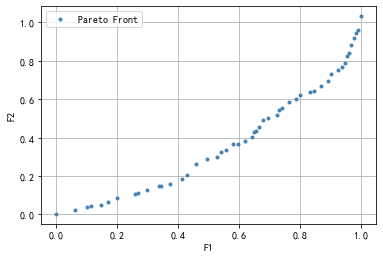

用时：25.331254 秒
评价次数：25000次
非支配个体数：50个
单位时间找到帕累托前沿点个数：1个
种群信息导出完毕。


In [57]:
"""不做数据预处理得出结果如下，PINAW最大还是接近1，区间结果基本变化不大"""

In [58]:
# 从非支配种群中随便拉出一个解来看看训练集的预测结果
print(NDSet.ObjV[13])

Q = NDSet.Phen[13]
SB = Q.reshape((10, 2))

Telm.nnet.set_B(SB)

bb=Telm.predict(gx)
print(bb)


"""可以看出得到的结果变化不多，为直线类型"""

[0.97709924 0.91610408]
[[194.6751187  694.88469296]
 [194.67512968 694.88453387]
 [206.66349769 521.28032537]
 [194.88541632 691.83936167]
 [194.67510612 694.88487504]
 [194.6757452  694.87562058]
 [206.80613129 519.21483927]
 [207.11156419 514.79184995]
 [207.08733316 515.14274088]
 [194.73995428 693.94580241]
 [194.67509814 694.88499071]
 [194.67509813 694.88499074]
 [194.67509813 694.88499074]
 [194.67509813 694.88499074]
 [194.67509813 694.88499074]
 [194.67507442 694.88495948]
 [194.67141883 694.88017194]
 [207.09180828 515.07793636]
 [201.28041787 507.16731053]
 [201.24095061 507.09123139]
 [201.28051369 507.16749524]
 [201.36613984 507.27945376]
 [207.11088568 514.80167549]
 [194.67513193 694.88450131]
 [203.55456124 566.30100304]
 [194.68880256 694.68653623]
 [194.81457298 692.8652479 ]
 [206.91985932 517.56793864]
 [207.1114771  514.79311118]
 [207.11149025 514.79194776]
 [207.04878119 514.70973467]
 [201.53333109 507.49806405]
 [201.13921405 509.21522558]
 [188.84404611 687.

'可以看出得到的结果非常脱离实际，之后尝试了其他数据预处理方法 ：MinMaxScaler 和 RobustScaler\n   最大的PINAW可以缩小一点，到3-5左右，但预测结果依旧脱离实际'

In [ ]:
------------------------------------------------------------------------------------

# 后面是草稿

In [35]:
"""===============================导入数据==========================="""
dat = pd.read_csv('SH18.csv')
gy = np.array(dat["volume"])[1:132]
LL = np.array(dat["LL"])[1:132]
UU = np.array(dat["UU"])[1:132]
sea = np.array(dat["sea"])[0:131]
f1 = np.array(dat["CIMF1"])[0:131]
f2 = np.array(dat["CIMF2"])[0:131]
f3 = np.array(dat["CIMF3"])[0:131]
f4 = np.array(dat["CIMF4"])[0:131]
f5 = np.array(dat["CR"])[0:131]

gx=np.column_stack((sea,f1,f2,f3,f4,f5))# 训练集的输入
gy2=np.column_stack((LL,UU))# 训练集的输出（假的上下边界）
gy.resize((131, 1))# 训练集对应的输出真实值

seat = np.array(dat["sea"])[131:143]
f1t = np.array(dat["CIMF1"])[131:143]
f2t = np.array(dat["CIMF2"])[131:143]
f3t = np.array(dat["CIMF3"])[131:143]
f4t = np.array(dat["CIMF4"])[131:143]
f5t = np.array(dat["CR"])[131:143]

testt = np.array(dat["volume"])[132:144]
testt.resize((12, 1))# 测试集对应的输出真实值

gxt=np.column_stack((seat,f1t,f2t,f3t,f4t,f5t))# 测试集的输入


"""===============================数据预处理，只对输入做处理==========================="""
scaler1 = MinMaxScaler()


scaler1.fit(gx)


gx = scaler1.transform(gx)  
gxt = scaler1.transform(gxt)

In [39]:
"""===============================用假的上下边界训练一下ELM，顺便随机生成隐含层的权值W和阈值B==========================="""
Telm = ELM(6, 2)
Telm.add_neurons(10, "sigm")
Telm.train(gx, gy2, "r")
bb = Telm.predict(gx)
print(bb)# 观察一下结果

"""===============================计算结果的PICP 和 PINAW==========================="""
LOW = []
UP = []

for s in range(0,131):
    if bb[s,0] >= bb[s,1]:
        LOW.append(bb[s,1])
        UP.append(bb[s,0])
    else:
        LOW.append(bb[s,0])
        UP.append(bb[s,1])

ACE = 0
    
for s in range(0,131):
    if gy[s] >= LOW[s] and gy[s] <= UP[s]:
        eve = 1
    else:
        eve = 0
    ACE = ACE + eve

PICP = ACE/gy.shape[0]
    

PIW = np.mean(UP)- np.mean(LOW)
PINAW= PIW/(max(gy)- min(gy))
print('PICP=',PICP,'PINAW=',PINAW)# 可以看出假边界数据训练的结果虽然不好，但表现的挺正常，

[[192.64970869 276.58592037]
 [195.70057221 278.6916557 ]
 [188.79567123 276.6842838 ]
 [203.45857584 290.598635  ]
 [196.58526802 282.42945982]
 [190.14963276 276.44479008]
 [220.9260031  307.7333463 ]
 [232.72521008 319.62041739]
 [210.71315614 297.08359842]
 [217.37588821 303.61484279]
 [211.54499762 296.36938162]
 [183.73229757 269.22422259]
 [190.40616377 275.1293692 ]
 [181.03331819 266.47926563]
 [200.18863335 285.31419958]
 [196.40035977 281.59488064]
 [177.24668268 262.37510453]
 [155.48946054 241.14142034]
 [182.62097722 268.23601822]
 [183.78547914 269.79649162]
 [172.92860604 258.02370537]
 [193.39721483 278.43092112]
 [173.00191675 257.95260313]
 [164.97110235 249.60624434]
 [182.30208746 267.13460012]
 [178.79658745 263.76619538]
 [208.60659641 293.7455922 ]
 [222.39981548 307.29199371]
 [205.8854514  291.20350172]
 [203.69582942 288.27064823]
 [237.05243751 324.08611604]
 [252.27673045 339.82039463]
 [246.56777341 332.85154083]
 [269.34420205 355.44338349]
 [218.65908159

In [40]:
"""===============================定义多目标优化算法要解决的问题==========================="""

class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'MyProblem' # 初始化name（函数名称，可以随意设置）
        M = 2 # 初始化M（目标维数）
        maxormins = [-1,1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 20 # 初始化Dim（决策变量维数，即ELM的输出层的权值矩阵10*2）
        varTypes = [0]* Dim # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [-10000] * Dim # 决策变量下界
        ub = [10000] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
    
    def aimFunc(self, pop): # 目标函数，f1是PICP，f2是PINAW
        Vars = pop.Phen # 得到决策变量矩阵
        pop.ObjV = np.zeros((pop.sizes, 2)) # 初始化种群个体目标函数值列向量
        for i in range(0,pop.sizes):# 计算目标函数值
            Q = Vars[i]
            SB = Q.reshape((10, 2))
            
            Telm.nnet.set_B(SB)# 把优化算法得出的权值B矩阵带入ELM
    
            bb=Telm.predict(gx)
            LOW = []
            UP = []

            for s in range(0,131):  # 计算上下边界
                if bb[s,0] >= bb[s,1]:
                    LOW.append(bb[s,1])
                    UP.append(bb[s,0])
                else:
                    LOW.append(bb[s,0])
                    UP.append(bb[s,1])

            ACE = 0
    
            for s in range(0,gy.shape[0]):
                if gy[s] >= LOW[s] and gy[s] <= UP[s]:
                     eve = 1
                else:
                     eve = 0
                ACE = ACE + eve

            f1 = ACE/gy.shape[0]# 计算PICP
    

            PIW = np.mean(UP)- np.mean(LOW)
            f2 = PIW/(max(gy)- min(gy))# 计算PINAW
            pop.ObjV[i] = [f1,f2] 


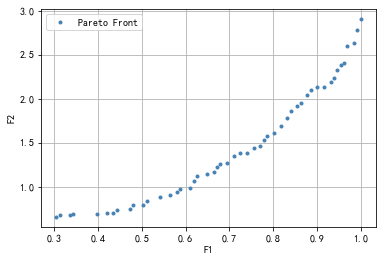

用时：21.913417 秒
评价次数：25000次
非支配个体数：50个
单位时间找到帕累托前沿点个数：2个
种群信息导出完毕。


In [45]:
"""===============================运行优化算法，得出结果==========================="""

if __name__ == '__main__':
    """===============================实例化问题对象==========================="""
    problem = MyProblem() # 生成问题对象
    """=================================种群设置==============================="""
    Encoding = 'RI'       # 编码方式
    NIND = 50             # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """===============================算法参数设置============================="""
    myAlgorithm = ea.moea_NSGA2_templet(problem, population) # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 500 # 最大进化代数
    myAlgorithm.drawing = 1   # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制过程动画）
    """===========================调用算法模板进行种群进化===========================
    调用run执行算法模板，得到帕累托最优解集NDSet。NDSet是一个种群类Population的对象。
    NDSet.ObjV为最优解个体的目标函数值；NDSet.Phen为对应的决策变量值。
    """
    NDSet = myAlgorithm.run() # 执行算法模板，得到非支配种群
    print('用时：%f 秒'%(myAlgorithm.passTime))
    print('评价次数：%d次'%(myAlgorithm.evalsNum))
    print('非支配个体数：%d个'%(NDSet.sizes))
    print('单位时间找到帕累托前沿点个数：%d个'%(int(NDSet.sizes //myAlgorithm.passTime)))
NDSet.save()

In [46]:
# 从上图可以看出得到的解非常的失败，PINAW甚至都大于1，从非支配种群中随便拉出一个解来看看训练集的预测结果
print(NDSet.ObjV[13])

Q = NDSet.Phen[13]
SB = Q.reshape((10, 2))

Telm.nnet.set_B(SB)

bb=scaler3.inverse_transform(Telm.predict(gx))
print(bb)

# 可以看出得到的结果非常脱离实际

[0.70992366 1.34799403]
[[ 106717.22349661   58216.51700869]
 [  93682.79759515   67481.49094705]
 [ 148052.38618618   56307.15110625]
 [ 119646.6476937    22543.35114935]
 [ 109036.81535057   28982.15947459]
 [  97905.1409205    39000.5405428 ]
 [  14449.49075582  -11830.48916169]
 [ -10773.07223426  -11216.98908576]
 [ -21467.9974581    -2366.63223708]
 [ -27247.50437231  -52275.97984045]
 [  50529.54937747   -4951.33063726]
 [ 147396.57259982   25434.93791627]
 [ 153802.07830558   30999.52411471]
 [ 175957.67418364   23237.66176356]
 [ 141102.78851744  -15374.94884966]
 [ 138754.676704    -32779.15861942]
 [ 153286.35519544  -17662.26941594]
 [ 144914.86341301     584.68696158]
 [  37894.2837798   -32436.7071541 ]
 [ -18156.09154427  -20265.7033976 ]
 [ -38828.11078588  -26719.15127768]
 [  35016.95115799   -1758.39799276]
 [ 101742.81880769    1876.66470915]
 [ 124183.59805286   30934.06662128]
 [  70785.01069569   25551.86310444]
 [  69158.5422338    38497.63729752]
 [  72626.5158

In [47]:
"""===============================导入数据==========================="""
dat = pd.read_csv('SH18.csv')
gy = np.array(dat["volume"])[1:132]
LL = np.array(dat["LL"])[1:132]
UU = np.array(dat["UU"])[1:132]
sea = np.array(dat["sea"])[0:131]
f1 = np.array(dat["CIMF1"])[0:131]
f2 = np.array(dat["CIMF2"])[0:131]
f3 = np.array(dat["CIMF3"])[0:131]
f4 = np.array(dat["CIMF4"])[0:131]
f5 = np.array(dat["CR"])[0:131]

gx=np.column_stack((sea,f1,f2,f3,f4,f5))# 训练集的输入
gy2=np.column_stack((LL,UU))# 训练集的输出（假的上下边界）
gy.resize((131, 1))# 训练集对应的输出真实值

seat = np.array(dat["sea"])[131:143]
f1t = np.array(dat["CIMF1"])[131:143]
f2t = np.array(dat["CIMF2"])[131:143]
f3t = np.array(dat["CIMF3"])[131:143]
f4t = np.array(dat["CIMF4"])[131:143]
f5t = np.array(dat["CR"])[131:143]

testt = np.array(dat["volume"])[132:144]
testt.resize((12, 1))# 测试集对应的输出真实值

gxt=np.column_stack((seat,f1t,f2t,f3t,f4t,f5t))# 测试集的输入


"""===============================数据预处理，只对输入做处理==========================="""
scaler1 = RobustScaler()


scaler1.fit(gx)


gx = scaler1.transform(gx)  
gxt = scaler1.transform(gxt)

In [48]:
"""===============================用假的上下边界训练一下ELM，顺便随机生成隐含层的权值W和阈值B==========================="""
Telm = ELM(6, 2)
Telm.add_neurons(10, "sigm")
Telm.train(gx, gy2, "r")
bb = Telm.predict(gx)
print(bb)# 观察一下结果

"""===============================计算结果的PICP 和 PINAW==========================="""
LOW = []
UP = []

for s in range(0,131):
    if bb[s,0] >= bb[s,1]:
        LOW.append(bb[s,1])
        UP.append(bb[s,0])
    else:
        LOW.append(bb[s,0])
        UP.append(bb[s,1])

ACE = 0
    
for s in range(0,131):
    if gy[s] >= LOW[s] and gy[s] <= UP[s]:
        eve = 1
    else:
        eve = 0
    ACE = ACE + eve

PICP = ACE/gy.shape[0]
    

PIW = np.mean(UP)- np.mean(LOW)
PINAW= PIW/(max(gy)- min(gy))
print('PICP=',PICP,'PINAW=',PINAW)# 可以看出假边界数据训练的结果虽然不好，但表现的挺正常，

[[168.90816593 255.75197649]
 [174.27877359 261.48234232]
 [233.78230137 323.68651633]
 [206.4830179  296.18999239]
 [177.51373104 263.35083821]
 [171.46668225 255.88857088]
 [195.45072175 277.8009077 ]
 [199.89458962 283.36943006]
 [183.6077014  266.99969316]
 [260.41970662 346.62828567]
 [168.15945004 253.8413738 ]
 [217.98189341 313.89431146]
 [258.79072362 334.74471387]
 [224.06039275 315.92059064]
 [228.99279438 313.0588217 ]
 [247.37474779 329.39816385]
 [247.30388943 326.7218569 ]
 [153.29858395 237.93213476]
 [244.72559309 331.31540713]
 [257.8893074  345.31631273]
 [210.0318039  284.9998236 ]
 [207.16514669 290.70827419]
 [178.27625205 263.38807507]
 [193.22391218 277.88756066]
 [175.22159042 261.10477237]
 [178.46749505 258.79544235]
 [231.87996683 310.71213785]
 [187.11910187 271.63175221]
 [186.96775404 272.10807398]
 [235.45448463 317.47561015]
 [280.63344598 371.78623   ]
 [301.98088411 394.9833079 ]
 [267.5168868  351.48846778]
 [335.54248757 428.51869923]
 [221.61114285

In [49]:
"""===============================定义多目标优化算法要解决的问题==========================="""

class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'MyProblem' # 初始化name（函数名称，可以随意设置）
        M = 2 # 初始化M（目标维数）
        maxormins = [-1,1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 20 # 初始化Dim（决策变量维数，即ELM的输出层的权值矩阵10*2）
        varTypes = [0]* Dim # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [-10000] * Dim # 决策变量下界
        ub = [10000] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
    
    def aimFunc(self, pop): # 目标函数，f1是PICP，f2是PINAW
        Vars = pop.Phen # 得到决策变量矩阵
        pop.ObjV = np.zeros((pop.sizes, 2)) # 初始化种群个体目标函数值列向量
        for i in range(0,pop.sizes):# 计算目标函数值
            Q = Vars[i]
            SB = Q.reshape((10, 2))
            
            Telm.nnet.set_B(SB)# 把优化算法得出的权值B矩阵带入ELM
    
            bb=Telm.predict(gx)
            LOW = []
            UP = []

            for s in range(0,131):  # 计算上下边界
                if bb[s,0] >= bb[s,1]:
                    LOW.append(bb[s,1])
                    UP.append(bb[s,0])
                else:
                    LOW.append(bb[s,0])
                    UP.append(bb[s,1])

            ACE = 0
    
            for s in range(0,gy.shape[0]):
                if gy[s] >= LOW[s] and gy[s] <= UP[s]:
                     eve = 1
                else:
                     eve = 0
                ACE = ACE + eve

            f1 = ACE/gy.shape[0]# 计算PICP
    

            PIW = np.mean(UP)- np.mean(LOW)
            f2 = PIW/(max(gy)- min(gy))# 计算PINAW
            pop.ObjV[i] = [f1,f2] 


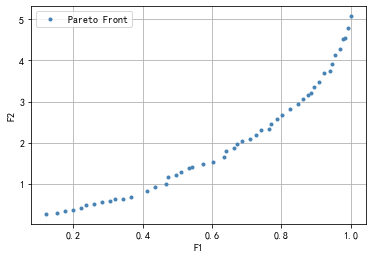

用时：21.740875 秒
评价次数：25000次
非支配个体数：50个
单位时间找到帕累托前沿点个数：2个
种群信息导出完毕。


In [52]:
"""===============================运行优化算法，得出结果==========================="""

if __name__ == '__main__':
    """===============================实例化问题对象==========================="""
    problem = MyProblem() # 生成问题对象
    """=================================种群设置==============================="""
    Encoding = 'RI'       # 编码方式
    NIND = 50             # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """===============================算法参数设置============================="""
    myAlgorithm = ea.moea_NSGA2_templet(problem, population) # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 500 # 最大进化代数
    myAlgorithm.drawing = 1   # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制过程动画）
    """===========================调用算法模板进行种群进化===========================
    调用run执行算法模板，得到帕累托最优解集NDSet。NDSet是一个种群类Population的对象。
    NDSet.ObjV为最优解个体的目标函数值；NDSet.Phen为对应的决策变量值。
    """
    NDSet = myAlgorithm.run() # 执行算法模板，得到非支配种群
    print('用时：%f 秒'%(myAlgorithm.passTime))
    print('评价次数：%d次'%(myAlgorithm.evalsNum))
    print('非支配个体数：%d个'%(NDSet.sizes))
    print('单位时间找到帕累托前沿点个数：%d个'%(int(NDSet.sizes //myAlgorithm.passTime)))
NDSet.save()

In [ ]:
# 从上图可以看出得到的解非常的失败，PINAW甚至都大于1，从非支配种群中随便拉出一个解来看看训练集的预测结果
print(NDSet.ObjV[13])

Q = NDSet.Phen[13]
SB = Q.reshape((10, 2))

Telm.nnet.set_B(SB)

bb=scaler3.inverse_transform(Telm.predict(gx))
print(bb)

# 可以看出得到的结果非常脱离实际

In [92]:
import geatpy as ea
from multiprocessing.dummy import Pool as ThreadPool
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'MyProblem' # 初始化name（函数名称，可以随意设置）
        M = 2 # 初始化M（目标维数）
        maxormins = [-1,1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 92 # 初始化Dim（决策变量维数）
        varTypes = [0]* Dim # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [-10000] * Dim # 决策变量下界
        ub = [10000] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
    
    def aimFunc(self, pop): # 目标函数，采用多线程加速计算
        Vars = pop.Phen # 得到决策变量矩阵
        pop.ObjV = np.zeros((pop.sizes, 2)) # 初始化种群个体目标函数值列向量
        for i in range(0,pop.sizes):
            Q = Vars[i]
            model.set_weights(Q)
    
            bb=model.predict(gx)
            LOW = []
            UP = []

            for s in range(0,131):
                if bb[s,0] >= bb[s,1]:
                    LOW.append(bb[s,1])
                    UP.append(bb[s,0])
                else:
                    LOW.append(bb[s,0])
                    UP.append(bb[s,1])

            ACE = 0
    
            for s in range(0,gy.shape[0]):
                if gy[s] >= LOW[s] and gy[s] <= UP[s]:
                     eve = 1
                else:
                     eve = 0
                ACE = ACE + eve

            f1 = ACE/gy.shape[0]
    

            PIW = np.mean(UP)- np.mean(LOW)
            f2 = PIW/(max(gy)- min(gy))
            pop.ObjV[i] = [f1,f2] 


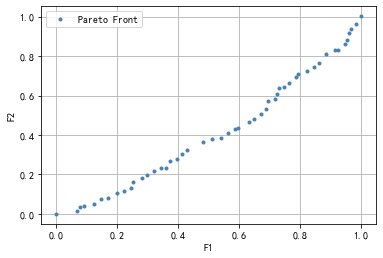

用时：20.987032 秒
评价次数：25000次
非支配个体数：50个
单位时间找到帕累托前沿点个数：2个


In [93]:
import numpy as np
import geatpy as ea # import geatpy

if __name__ == '__main__':
    """===============================实例化问题对象==========================="""
    problem = MyProblem() # 生成问题对象
    """=================================种群设置==============================="""
    Encoding = 'RI'       # 编码方式
    NIND = 50             # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """===============================算法参数设置============================="""
    myAlgorithm = ea.moea_NSGA2_templet(problem, population) # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 500 # 最大进化代数
    myAlgorithm.drawing = 1   # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制过程动画）
    """===========================调用算法模板进行种群进化===========================
    调用run执行算法模板，得到帕累托最优解集NDSet。NDSet是一个种群类Population的对象。
    NDSet.ObjV为最优解个体的目标函数值；NDSet.Phen为对应的决策变量值。
    详见Population.py中关于种群类的定义。
    """
    NDSet = myAlgorithm.run() # 执行算法模板，得到非支配种群
    print('用时：%f 秒'%(myAlgorithm.passTime))
    print('评价次数：%d次'%(myAlgorithm.evalsNum))
    print('非支配个体数：%d个'%(NDSet.sizes))
    print('单位时间找到帕累托前沿点个数：%d个'%(int(NDSet.sizes //myAlgorithm.passTime)))

In [94]:
NDSet.save()

种群信息导出完毕。


In [96]:
print(NDSet.ObjV[12])

[0.78625954 0.69448223]


In [76]:
print(gx)

[[2.35133476e-01 3.85371454e-01 5.12468037e-01 1.82418903e-02
  7.62919956e-01 0.00000000e+00]
 [1.74020973e-01 3.53527127e-01 4.68221410e-01 0.00000000e+00
  7.65961992e-01 5.22021695e-04]
 [4.53240737e-01 6.72761675e-01 5.11609659e-01 1.97125810e-02
  7.64743596e-01 1.14727014e-03]
 [5.36734520e-01 5.12881680e-01 5.72820691e-01 7.65096594e-02
  7.59257284e-01 1.87260554e-03]
 [4.19099736e-01 4.36762171e-01 5.90143984e-01 1.68239536e-01
  7.49593666e-01 2.69973593e-03]
 [3.91909381e-01 5.74102024e-01 5.33377944e-01 2.90099011e-01
  7.35847991e-01 3.62973753e-03]
 [6.71722522e-01 4.65637962e-01 4.16291700e-01 4.28519241e-01
  7.18116556e-01 4.66352746e-03]
 [7.44056026e-01 6.02794474e-01 3.07357754e-01 5.65032492e-01
  6.96495724e-01 5.80201233e-03]
 [5.96674239e-01 5.18892148e-01 3.01886741e-01 6.83294360e-01
  6.71082046e-01 7.04606992e-03]
 [6.93380217e-01 3.45354462e-01 4.23518610e-01 7.77608363e-01
  6.41972237e-01 8.39655381e-03]
 [4.06804418e-01 6.83041644e-01 6.38620975e-01 8.4

In [98]:
model.set_weights(NDSet.Phen[12])
bb=model.predict(gxt)

print(bb)

[[229.33007028 529.42973206]
 [229.33007028 529.42973206]
 [229.33007028 529.42973206]
 [229.33007028 529.42973206]
 [229.33007028 529.42973206]
 [229.33007028 529.42973206]
 [229.33007028 529.42973206]
 [229.33007028 529.42973206]
 [229.33007028 529.42973206]
 [229.33007028 529.42973206]
 [229.33007028 529.42973206]
 [229.33007028 529.42973206]]


In [11]:
model.set_weights(NDSet.Phen[16])
bb=model.predict(gxt)
LOW = []
UP = []

for s in range(0,12):
    if bb[s,0] >= bb[s,1]:
        LOW.append(bb[s,1])
        UP.append(bb[s,0])
    else:
        LOW.append(bb[s,0])
        UP.append(bb[s,1])

ACE = 0
    
for s in range(0,12):
    if testt[s] >= LOW[s] and testt[s] <= UP[s]:
        eve = 1
    else:
        eve = 0
    ACE = ACE + eve

PICP = ACE/12
    

PIW = np.mean(UP)- np.mean(LOW)
PINAW= PIW/(max(testt)- min(testt))
print(PICP,PINAW)

0.4166666666666667 [4.73703961]


In [17]:
model.set_weights(NDSet.Phen[6])
bb=model.predict(gx)
LOW = []
UP = []

for s in range(0,131):
    if bb[s,0] >= bb[s,1]:
        LOW.append(bb[s,1])
        UP.append(bb[s,0])
    else:
        LOW.append(bb[s,0])
        UP.append(bb[s,1])

ACE = 0
    
for s in range(0,131):
    if gy[s] >= LOW[s] and gy[s] <= UP[s]:
        eve = 1
    else:
        eve = 0
    ACE = ACE + eve

PICP = ACE/gy.shape[0]
    

PIW = np.mean(UP)- np.mean(LOW)
PINAW= PIW/(max(gy)- min(gy))
print(PICP,PINAW)

0.0 [1.63703698e-05]


In [18]:
print(bb)

[[291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851 291.08727454]
 [291.09434851

In [ ]:
------------------------------------------------------------------------------------

In [23]:
import geatpy as ea
from multiprocessing.dummy import Pool as ThreadPool
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'MyProblem' # 初始化name（函数名称，可以随意设置）
        M = 2 # 初始化M（目标维数）
        maxormins = [-1,1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 92 # 初始化Dim（决策变量维数）
        varTypes = [0]* Dim # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [-10000] * Dim # 决策变量下界
        ub = [10000] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
    
    def aimFunc(self, pop): # 目标函数，采用多线程加速计算
        Vars = pop.Phen # 得到决策变量矩阵
        pop.ObjV = np.zeros((pop.sizes, 2)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            Q = Vars[i]
            model.set_weights(Q)
    
            bb=model.predict(gx)
            LOW = []
            UP = []

            for s in range(0,131):
                if bb[s,0] >= bb[s,1]:
                    LOW.append(bb[s,1])
                    UP.append(bb[s,0])
                else:
                    LOW.append(bb[s,0])
                    UP.append(bb[s,1])

            ACE = 0
    
            for s in range(0,gy.shape[0]):
                if gy[s] >= LOW[s] and gy[s] <= UP[s]:
                     eve = 1
                else:
                     eve = 0
                ACE = ACE + eve

            f1 = ACE/gy.shape[0]
    

            PIW = np.mean(UP)- np.mean(LOW)
            f2 = PIW/(max(gy)- min(gy))
            pop.ObjV[i] = [f1,f2] # 把交叉验证的平均得分作为目标函数值
            
        pool = ThreadPool(4) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes)))




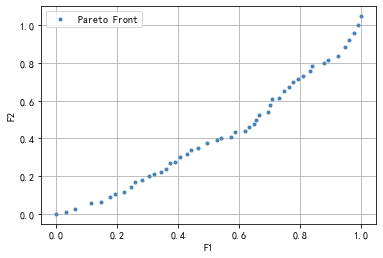

用时：343.734678 秒
评价次数：25000次
非支配个体数：50个
单位时间找到帕累托前沿点个数：0个


In [38]:
import numpy as np
import geatpy as ea # import geatpy

if __name__ == '__main__':
    """===============================实例化问题对象==========================="""
    problem = MyProblem() # 生成问题对象
    """=================================种群设置==============================="""
    Encoding = 'RI'       # 编码方式
    NIND = 50             # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """===============================算法参数设置============================="""
    myAlgorithm = ea.moea_NSGA2_templet(problem, population) # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 500 # 最大进化代数
    myAlgorithm.drawing = 1   # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制过程动画）
    """===========================调用算法模板进行种群进化===========================
    调用run执行算法模板，得到帕累托最优解集NDSet。NDSet是一个种群类Population的对象。
    NDSet.ObjV为最优解个体的目标函数值；NDSet.Phen为对应的决策变量值。
    详见Population.py中关于种群类的定义。
    """
    NDSet = myAlgorithm.run() # 执行算法模板，得到非支配种群
    print('用时：%f 秒'%(myAlgorithm.passTime))
    print('评价次数：%d次'%(myAlgorithm.evalsNum))
    print('非支配个体数：%d个'%(NDSet.sizes))
    print('单位时间找到帕累托前沿点个数：%d个'%(int(NDSet.sizes //myAlgorithm.passTime)))


In [ ]:
----------------------------------------------------------------------------------

In [14]:
dat = pd.read_csv('SH18.csv')
gy = np.array(dat["seares"])[1:132]
f1 = np.array(dat["CIMF1"])[0:131]
f2 = np.array(dat["CIMF2"])[0:131]
f3 = np.array(dat["CIMF3"])[0:131]
f4 = np.array(dat["CIMF4"])[0:131]
f5 = np.array(dat["CR"])[0:131]

gx=np.column_stack((f1,f2,f3,f4,f5,))
gy.resize((131, 1))

f1t = np.array(dat["CIMF1"])[131:143]
f2t = np.array(dat["CIMF2"])[131:143]
f3t = np.array(dat["CIMF3"])[131:143]
f4t = np.array(dat["CIMF4"])[131:143]
f5t = np.array(dat["CR"])[131:143]

testt = np.array(dat["seares"])[132:144]
testt.resize((12, 1))

gxt=np.column_stack((f1t,f2t,f3t,f4t,f5t))

ndim = [5, 10, 2]
model = MLPNetwork(ndim, act_funcs=["tanh", "linear"], cost_function="mse")
model.initialize_weights()

In [16]:
import geatpy as ea
from multiprocessing.dummy import Pool as ThreadPool
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'MyProblem' # 初始化name（函数名称，可以随意设置）
        M = 2 # 初始化M（目标维数）
        maxormins = [-1,1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 82 # 初始化Dim（决策变量维数）
        varTypes = [0]* Dim # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        lb = [-10000] * Dim # 决策变量下界
        ub = [10000] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
    
    def aimFunc(self, pop): # 目标函数，采用多线程加速计算
        Vars = pop.Phen # 得到决策变量矩阵
        pop.ObjV = np.zeros((pop.sizes, 2)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            Q = Vars[i]
            model.set_weights(Q)
    
            bb=model.predict(gx)
            LOW = []
            UP = []

            for s in range(0,131):
                if bb[s,0] >= bb[s,1]:
                    LOW.append(bb[s,1])
                    UP.append(bb[s,0])
                else:
                    LOW.append(bb[s,0])
                    UP.append(bb[s,1])

            ACE = 0
    
            for s in range(0,gy.shape[0]):
                if gy[s] >= LOW[s] and gy[s] <= UP[s]:
                     eve = 1
                else:
                     eve = 0
                ACE = ACE + eve

            f1 = ACE/gy.shape[0]
    

            PIW = np.mean(UP)- np.mean(LOW)
            f2 = PIW/(max(gy)- min(gy))
            pop.ObjV[i] = [f1,f2] # 把交叉验证的平均得分作为目标函数值
            
        pool = ThreadPool(4) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes)))



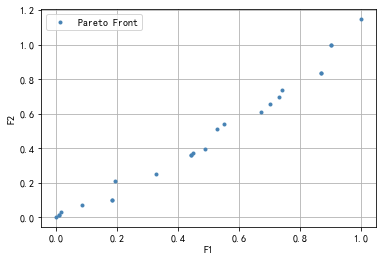

用时：72.217171 秒
评价次数：30000次
非支配个体数：24个
单位时间找到帕累托前沿点个数：0个


In [20]:
import numpy as np
import geatpy as ea # import geatpy

if __name__ == '__main__':
    """===============================实例化问题对象==========================="""
    problem = MyProblem() # 生成问题对象
    """=================================种群设置==============================="""
    Encoding = 'RI'       # 编码方式
    NIND = 100             # 种群规模
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
    population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
    """===============================算法参数设置============================="""
    myAlgorithm = ea.moea_NSGA2_templet(problem, population) # 实例化一个算法模板对象
    myAlgorithm.MAXGEN = 300 # 最大进化代数
    myAlgorithm.drawing = 1   # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制过程动画）
    """===========================调用算法模板进行种群进化===========================
    调用run执行算法模板，得到帕累托最优解集NDSet。NDSet是一个种群类Population的对象。
    NDSet.ObjV为最优解个体的目标函数值；NDSet.Phen为对应的决策变量值。
    详见Population.py中关于种群类的定义。
    """
    NDSet = myAlgorithm.run() # 执行算法模板，得到非支配种群
    print('用时：%f 秒'%(myAlgorithm.passTime))
    print('评价次数：%d次'%(myAlgorithm.evalsNum))
    print('非支配个体数：%d个'%(NDSet.sizes))
    print('单位时间找到帕累托前沿点个数：%d个'%(int(NDSet.sizes //myAlgorithm.passTime)))



In [ ]:
--------------------------------------------------------------------------------

In [2]:
import numpy as np
a=np.arange(9).reshape(3,3)
print(a)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


In [10]:
b = a[:, [0]]
c=a[:, [1]]
print(b)

[[0]
 [3]
 [6]]


In [11]:
f1 = -25 * (b - 2)**2 - (c - 2)**2
f2 = (b - 1)**2 + (c - 1)**2
print(f1)

[[-101]
 [ -29]
 [-425]]


In [12]:
ObjV = np.hstack([f1, f2])
print(ObjV)

[[-101    1]
 [ -29   13]
 [-425   61]]


In [13]:
m=a[1]
print(m)

[3 4 5]


In [14]:
ObjV = np.zeros((3,2 ))
a=1 
b=2
ObjV[0]=[a,b]
print(ObjV)

[[1. 2.]
 [0. 0.]
 [0. 0.]]


In [24]:
xxx = np.zeros((3,2 ))
print(xxx)
a=1 
b=2
xxx[0]=[a,b]
xxx[1]=[a,b]
print(xxx)

[[0. 0.]
 [0. 0.]
 [0. 0.]]
[[1. 2.]
 [1. 2.]
 [0. 0.]]


In [39]:
    #计算指标
    NDSet.save()
    PF = problem.getReferObjV()#获取真实前沿
    if PF is not None and NDSet.sizes != 0:
        GD = ea.indicator.GD(NDSet.ObjV, PF)#计算GD指标
        IGD = ea.indicator.IGD(NDSet.ObjV, PF)#计算IGD指标
        HV = ea.indicator.HV(NDSet.ObjV, PF)#计算HV指标
        Spacing = ea.indicator.Spacing(NDSet.ObjV)#计算Spacing指标print('GD:%f'%GD)
        print('IGD:%f'%IGD)
        print('HV:%f'%HV)
        print('Spacing:%f'%Spacing)
        """=====================进化过程指标追踪分析========================"""
    if PF is not None:
        metricName = [['IGD'], ['HV']]
        [NDSet_trace, Metrics] =ea.indicator.moea_tracking(myAlgorithm.pop_trace, PF,metricName, problem.maxormins)
        #绘制指标追踪分析图
        ea.trcplot(Metrics, labels = metricName, titles = metricName)

种群信息导出完毕。
未找到目标函数参考值数据！


In [40]:
print(NDSet.Phen[3])

[ -5994.01242284  -2679.87467851   4484.33312617    -21.15489485
   6946.70678884    -33.75988554   3447.40639316  -4076.45694166
   9998.94907404   3449.10765252  -5528.91577907   4480.81704401
   1143.66587401  -2696.96172719  -5475.51907989  -6344.26685613
   2296.17782459  -4869.28148143   9286.38527429   3772.72159917
   7089.68410605  -5137.43401532   3977.16865534   7357.71629238
   4706.8947626    3593.7054406    2999.48101927    762.82678107
  -7608.00359768   -365.28448347   5848.55424781   7125.36749243
   2052.47791067   9165.09431141   4105.28866452   7364.50649815
  -6547.14351012  -6061.07308187   2281.34561599  -6411.54287189
  -6791.02573789  -4059.34827983   4381.64161349  -8450.38883407
   1738.96455165  -2249.56127668  -1703.77935175  -2535.62990904
  -8780.04587594   1651.50040799  -8843.21896702   2595.35847151
   1654.39093635   9343.02005155  -6592.32257602  -9378.80149004
  -7173.45283686  -7860.14105863   7269.22052728   5825.84814929
     99.56058138   7879.9

In [46]:
model.set_weights(NDSet.Phen[2])
bb=model.predict(gxt)
LOW = []
UP = []

for s in range(0,12):
    if bb[s,0] >= bb[s,1]:
        LOW.append(bb[s,1])
        UP.append(bb[s,0])
    else:
        LOW.append(bb[s,0])
        UP.append(bb[s,1])

ACE = 0
    
for s in range(0,12):
    if testt[s] >= LOW[s] and testt[s] <= UP[s]:
        eve = 1
    else:
        eve = 0
    ACE = ACE + eve

PICP = ACE/12
    

PIW = np.mean(UP)- np.mean(LOW)
PINAW= PIW/(max(testt)- min(testt))
print(PICP,PINAW)

1.0 [39.96541971]


In [50]:
model.set_weights(NDSet.Phen[38])
bb=model.predict(gx)
LOW = []
UP = []

for s in range(0,131):
    if bb[s,0] >= bb[s,1]:
        LOW.append(bb[s,1])
        UP.append(bb[s,0])
    else:
        LOW.append(bb[s,0])
        UP.append(bb[s,1])

ACE = 0
    
for s in range(0,131):
    if gy[s] >= LOW[s] and gy[s] <= UP[s]:
        eve = 1
    else:
        eve = 0
    ACE = ACE + eve

PICP = ACE/gy.shape[0]
    

PIW = np.mean(UP)- np.mean(LOW)
PINAW= PIW/(max(gy)- min(gy))
print(PICP,PINAW)

0.0 [37.27933105]


In [55]:
print(NDSet.Phen[38])
print(bb)

[-6227.8191631  -1772.23391612  4167.37742397  -996.03615685
  6942.41441213 -1470.20463583  3915.27112397 -4113.90216976
  9585.69912848  3504.97280727 -5525.3578667   4480.87963646
  1209.02027346 -2529.03750905 -5564.32323911 -6221.65966046
  2127.90285232 -4865.27614556  9287.28793939  3773.97730839
  6092.79832229  5643.38511321  4051.11978485  6567.56554238
  5026.93105339  3584.66329904  2871.34666806   861.11038825
 -7666.09813974 -3341.24974328  4975.38671021  7234.14189569
  2024.80763674 -3668.11755762  4104.074814    7354.48484514
 -6701.45813435 -6060.60941658  2908.655612   -5857.32481938
 -6791.00945753 -4032.78943074  4342.40218089 -8450.38883407
  7860.59634938 -2255.4005076  -1697.98737332 -3694.69693992
 -8508.73501567  2159.89958689 -8413.31757379  8413.5715768
  1626.57348763  9342.96591403 -6671.27469298 -9204.45467275
 -7315.48698519 -8559.71887593  7272.98248621 -3456.14229673
  -234.21208728  8160.72227851  5728.9216613   4599.523403
 -1269.0550516  -8128.05073

In [57]:
Vars =  NDSet.Phen
Q = Vars[38]
model.set_weights(Q)
    
bb=model.predict(gx)
LOW = []
UP = []

for s in range(0,131):
    if bb[s,0] >= bb[s,1]:
        LOW.append(bb[s,1])
        UP.append(bb[s,0])
    else:
        LOW.append(bb[s,0])
        UP.append(bb[s,1])

ACE = 0
    
for s in range(0,gy.shape[0]):
    if gy[s] >= LOW[s] and gy[s] <= UP[s]:
        eve = 1
    else:
        eve = 0
    ACE = ACE + eve

f1 = ACE/gy.shape[0]
    
PIW = np.mean(UP)- np.mean(LOW)
f2 = PIW/(max(gy)- min(gy))

print(f1,f2)

0.0 [37.27933105]


In [58]:
            Vars =  NDSet.Phen
            Q = Vars[38]
            model.set_weights(Q)
    
            bb=model.predict(gx)
            LOW = []
            UP = []

            for s in range(0,131):
                if bb[s,0] >= bb[s,1]:
                    LOW.append(bb[s,1])
                    UP.append(bb[s,0])
                else:
                    LOW.append(bb[s,0])
                    UP.append(bb[s,1])

            ACE = 0
    
            for s in range(0,gy.shape[0]):
                if gy[s] >= LOW[s] and gy[s] <= UP[s]:
                     eve = 1
                else:
                     eve = 0
                ACE = ACE + eve

            f1 = ACE/gy.shape[0]
    

            PIW = np.mean(UP)- np.mean(LOW)
            f2 = PIW/(max(gy)- min(gy))
            print(f1,f2)

0.0 [37.27933105]
